<a href="https://colab.research.google.com/github/TayJen/hackathon_algu2022/blob/master/H_ALGU_2022_Advance%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
%cd /content/drive/Shareddrives/data_drive/H_Vladivostok2022
!pwd

/content/drive/Shareddrives/data_drive/H_Vladivostok2022
/content/drive/Shareddrives/data_drive/H_Vladivostok2022


## Импорт библиотек

In [120]:
# Для работы с данными
import numpy as np
import pandas as pd

# Для моделей
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor

# Метрика
from sklearn.metrics import r2_score

%matplotlib inline
np.random.seed(59)

# Проверка гипотез, работа с данными

## Взгляд на данные

In [121]:
df = pd.read_csv('./data/prepared/train.csv')
df.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,...,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,text,comments_cnt,authors_cnt
0,5,93,93,10,1,5,57,SM,10678,ui тест по заказ добро кейджи,...,staff,fixed,1,1,1,1,1,NaN,0,0
1,5,93,93,10,1,5,59,SM,10679,ui тест раздел профиль,...,staff,fixed,1,1,1,1,1,приверять и принимать mr,1,1
2,5,93,93,10,1,6,0,SM,10680,ui тест раздел личный счет,...,staff,fixed,1,1,1,1,1,NaN,0,0
3,5,93,93,10,1,6,2,SM,10682,ui тест раздел новость,...,staff,fixed,1,1,1,1,1,NaN,0,0
4,5,93,93,10,1,6,3,SM,10683,ui тест раздел зона скидка и доплата,...,staff,fixed,1,1,1,1,1,принимать mr,1,1


In [122]:
df_test = pd.read_csv('./data/prepared/test.csv')
df_test.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,...,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,text,comments_cnt,authors_cnt
0,5,112,112,1,15,9,52,SM,11140,выгружать весь mp файл звонок на диск,...,staff,fixed,0,0,0,0,0,ресерч по rsync http losst ru rsync primery si...,8,1
1,5,112,112,1,15,9,54,SM,11141,удалять файл mp звонок с сервер до,...,staff,fixed,0,0,0,0,0,задача приостанавливать в связь с заморозка ра...,4,2
2,5,94,54,1,16,4,46,SM,11144,удалять окно выбор тариф и перенести функциона...,...,staff,fixed,0,0,0,0,0,задача закрывать в связь с передача проект,1,1
3,5,94,94,1,16,11,12,SM,11146,при авторизация пользователь водитель не видет...,...,staff,fixed,0,0,0,0,0,не правильно реализовать логика вызов метод ge...,2,2
4,5,1,54,1,17,5,19,SM,11150,основной проблема по корп отдел по состояние н...,...,unknown,unknown,0,0,0,0,0,ch keneskhanova прежде все по проблема коррект...,7,2


In [123]:
df['text'] = df['text'].fillna('')
df_test['text'] = df_test['text'].fillna('')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9589 entries, 0 to 9588
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   project_id                  9589 non-null   int64  
 1   assignee_id                 9589 non-null   int64  
 2   creator_id                  9589 non-null   int64  
 3   month                       9589 non-null   int64  
 4   day                         9589 non-null   int64  
 5   hour                        9589 non-null   int64  
 6   minute                      9589 non-null   int64  
 7   key_name                    9589 non-null   object 
 8   key_num                     9589 non-null   int64  
 9   lemm_summary                9589 non-null   object 
 10  log_target                  9589 non-null   float64
 11  active                      9589 non-null   int64  
 12  position                    9589 non-null   object 
 13  hiring_type                 9589 

## Общий tf-idf

Попробуем выполнить общий tf-idf, с ограничением в N токенов, как для описания задачи, так и для комментариев

In [124]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords_rus = stopwords.words("russian")
stopwords_eng = stopwords.words('english')
stopwords_all = stopwords_rus + stopwords_eng

summ_tf_idf = TfidfVectorizer(stop_words=stopwords_all, max_features=7000)
comm_tf_idf = TfidfVectorizer(stop_words=stopwords_all, max_features=3000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [125]:
len_train, len_test = len(df), len(df_test)
len_train, len_test

(9589, 1070)

In [126]:
df_general = pd.concat([df, df_test], axis=0, ignore_index=True)
df_general.shape

(10659, 23)

In [127]:
# X_summ_new = summ_tf_idf.fit_transform(df_general['lemm_summary'])
# feature_names_summ = list(map(lambda x: x + '_summ', summ_tf_idf.get_feature_names_out()))

# X_summ_new_df = pd.DataFrame(X_summ_new.toarray(), columns=feature_names_summ)
df_general.drop('lemm_summary', axis=1, inplace=True)
# df_general = pd.concat([df_general, X_summ_new_df], axis=1)

# df_general.shape

In [128]:
# X_comm_new = comm_tf_idf.fit_transform(df_general['text'])
# feature_names_comm = list(map(lambda x: x + '_comm', comm_tf_idf.get_feature_names_out()))

# X_comm_new_df = pd.DataFrame(X_comm_new.toarray(), columns=feature_names_comm)
df_general.drop('text', axis=1, inplace=True)
# df_general = pd.concat([df_general, X_comm_new_df], axis=1)

# df_general.shape

## Преобразование категориальных признаков

In [129]:
df.key_name.unique(), df_test.key_name.unique()

(array(['SM', 'BALT', 'BA', 'UN', 'FPY', 'XXO', 'ADBK', 'ADBKRK', 'LJ'],
       dtype=object),
 array(['SM', 'BALT', 'BAD', 'UN', 'FPY', 'XXO', 'ADBK', 'ADBKRK', 'LJ'],
       dtype=object))

In [130]:
df_general['key_name'] = df_general['key_name'].apply(lambda x: 'BA' if x == 'BAD' else x)
df_general.key_name.unique()

array(['SM', 'BALT', 'BA', 'UN', 'FPY', 'XXO', 'ADBK', 'ADBKRK', 'LJ'],
      dtype=object)

In [131]:
cat_features = ['key_name', 'position', 'hiring_type', 'payment_type']

ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                             unknown_value=-1)

df_general[cat_features] = ord_encoder.fit_transform(df_general[cat_features])

## Feature Engineering

In [132]:
df_general['creator_worker_diff'] = df_general['creator_id'] != df_general['assignee_id']
df_general['creator_worker_diff'].describe()

count     10659
unique        2
top       False
freq       7093
Name: creator_worker_diff, dtype: object

In [133]:
df_general.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,log_target,...,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,comments_cnt,authors_cnt,creator_worker_diff
0,5,93,93,10,1,5,57,6.0,10678,7.495542,...,1.0,0.0,1,1,1,1,1,0,0,False
1,5,93,93,10,1,5,59,6.0,10679,8.881836,...,1.0,0.0,1,1,1,1,1,1,1,False
2,5,93,93,10,1,6,0,6.0,10680,9.574983,...,1.0,0.0,1,1,1,1,1,0,0,False
3,5,93,93,10,1,6,2,6.0,10682,6.802395,...,1.0,0.0,1,1,1,1,1,0,0,False
4,5,93,93,10,1,6,3,6.0,10683,6.802395,...,1.0,0.0,1,1,1,1,1,1,1,False


In [134]:
df_general.drop(['is_nda_signed', 'is_added_to_internal_chats'],
                axis=1, inplace=True)
df_general.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,log_target,active,position,hiring_type,payment_type,passport,is_labor_contract_signed,is_added_one_to_one,comments_cnt,authors_cnt,creator_worker_diff
0,5,93,93,10,1,5,57,6.0,10678,7.495542,1,5.0,1.0,0.0,1,1,1,0,0,False
1,5,93,93,10,1,5,59,6.0,10679,8.881836,1,5.0,1.0,0.0,1,1,1,1,1,False
2,5,93,93,10,1,6,0,6.0,10680,9.574983,1,5.0,1.0,0.0,1,1,1,0,0,False
3,5,93,93,10,1,6,2,6.0,10682,6.802395,1,5.0,1.0,0.0,1,1,1,0,0,False
4,5,93,93,10,1,6,3,6.0,10683,6.802395,1,5.0,1.0,0.0,1,1,1,1,1,False


In [135]:
df_general.passport.unique(), df_general.active.unique()

(array([1, 0]), array([1, 0]))

In [136]:
df_general['active_pass'] = df_general['passport'] == df_general['active']
df_general.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,log_target,...,position,hiring_type,payment_type,passport,is_labor_contract_signed,is_added_one_to_one,comments_cnt,authors_cnt,creator_worker_diff,active_pass
0,5,93,93,10,1,5,57,6.0,10678,7.495542,...,5.0,1.0,0.0,1,1,1,0,0,False,True
1,5,93,93,10,1,5,59,6.0,10679,8.881836,...,5.0,1.0,0.0,1,1,1,1,1,False,True
2,5,93,93,10,1,6,0,6.0,10680,9.574983,...,5.0,1.0,0.0,1,1,1,0,0,False,True
3,5,93,93,10,1,6,2,6.0,10682,6.802395,...,5.0,1.0,0.0,1,1,1,0,0,False,True
4,5,93,93,10,1,6,3,6.0,10683,6.802395,...,5.0,1.0,0.0,1,1,1,1,1,False,True


In [137]:
group = df_general[:len_train - 1].groupby(['project_id']).agg({'log_target': ['mean']})
group.columns = ['proj_avg_target']
group.reset_index(inplace=True)

df_general = pd.merge(df_general, group, on=['project_id'], how='left')

In [138]:
group = df_general[:len_train - 1].groupby(['assignee_id']).agg({'log_target': ['mean']})
group.columns = ['assign_avg_target']
group.reset_index(inplace=True)

df_general = pd.merge(df_general, group, on=['assignee_id'], how='left')

In [139]:
group = df_general[:len_train - 1].groupby(['creator_id']).agg({'log_target': ['mean']})
group.columns = ['creator_avg_target']
group.reset_index(inplace=True)

df_general = pd.merge(df_general, group, on=['creator_id'], how='left')

In [140]:
group = df_general[:len_train - 1].groupby(['project_id', 'assignee_id']).agg({'log_target': ['mean']})
group.columns = ['proj_assign_avg_target']
group.reset_index(inplace=True)

df_general = pd.merge(df_general, group, on=['project_id', 'assignee_id'], how='left')

In [141]:
group = df_general[:len_train - 1].groupby(['project_id', 'creator_id']).agg({'log_target': ['mean']})
group.columns = ['proj_creator_avg_target']
group.reset_index(inplace=True)

df_general = pd.merge(df_general, group, on=['project_id', 'creator_id'], how='left')

In [142]:
df_general.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,log_target,...,is_added_one_to_one,comments_cnt,authors_cnt,creator_worker_diff,active_pass,proj_avg_target,assign_avg_target,creator_avg_target,proj_assign_avg_target,proj_creator_avg_target
0,5,93,93,10,1,5,57,6.0,10678,7.495542,...,1,0,0,False,True,9.122564,8.523019,8.606122,8.523019,8.606122
1,5,93,93,10,1,5,59,6.0,10679,8.881836,...,1,1,1,False,True,9.122564,8.523019,8.606122,8.523019,8.606122
2,5,93,93,10,1,6,0,6.0,10680,9.574983,...,1,0,0,False,True,9.122564,8.523019,8.606122,8.523019,8.606122
3,5,93,93,10,1,6,2,6.0,10682,6.802395,...,1,0,0,False,True,9.122564,8.523019,8.606122,8.523019,8.606122
4,5,93,93,10,1,6,3,6.0,10683,6.802395,...,1,1,1,False,True,9.122564,8.523019,8.606122,8.523019,8.606122


In [147]:
df_general.fillna(0, inplace=True)
df_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10659 entries, 0 to 10658
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   project_id                10659 non-null  int64  
 1   assignee_id               10659 non-null  int64  
 2   creator_id                10659 non-null  int64  
 3   month                     10659 non-null  int64  
 4   day                       10659 non-null  int64  
 5   hour                      10659 non-null  int64  
 6   minute                    10659 non-null  int64  
 7   key_name                  10659 non-null  float64
 8   key_num                   10659 non-null  int64  
 9   log_target                10659 non-null  float64
 10  active                    10659 non-null  int64  
 11  position                  10659 non-null  float64
 12  hiring_type               10659 non-null  float64
 13  payment_type              10659 non-null  float64
 14  passpo

## Разделение данных

In [148]:
df_train = df_general.loc[:len_train - 1].copy()
df_test = df_general.loc[len_train:].copy()
df_train.shape, df_test.shape

((9589, 26), (1070, 26))

In [149]:
df_train.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,log_target,...,is_added_one_to_one,comments_cnt,authors_cnt,creator_worker_diff,active_pass,proj_avg_target,assign_avg_target,creator_avg_target,proj_assign_avg_target,proj_creator_avg_target
0,5,93,93,10,1,5,57,6.0,10678,7.495542,...,1,0,0,False,True,9.122564,8.523019,8.606122,8.523019,8.606122
1,5,93,93,10,1,5,59,6.0,10679,8.881836,...,1,1,1,False,True,9.122564,8.523019,8.606122,8.523019,8.606122
2,5,93,93,10,1,6,0,6.0,10680,9.574983,...,1,0,0,False,True,9.122564,8.523019,8.606122,8.523019,8.606122
3,5,93,93,10,1,6,2,6.0,10682,6.802395,...,1,0,0,False,True,9.122564,8.523019,8.606122,8.523019,8.606122
4,5,93,93,10,1,6,3,6.0,10683,6.802395,...,1,1,1,False,True,9.122564,8.523019,8.606122,8.523019,8.606122


In [150]:
df_train.tail()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,log_target,...,is_added_one_to_one,comments_cnt,authors_cnt,creator_worker_diff,active_pass,proj_avg_target,assign_avg_target,creator_avg_target,proj_assign_avg_target,proj_creator_avg_target
9584,48,1,116,6,15,9,47,0.0,779,10.167389,...,0,0,0,True,False,8.774997,8.959089,9.015140,8.728317,9.015140
9585,56,2,2,6,2,10,8,5.0,1,9.692767,...,0,3,1,False,True,8.876587,8.876587,8.876587,8.876587,8.876587
9586,56,2,2,6,5,9,52,5.0,3,8.188689,...,0,0,0,False,True,8.876587,8.876587,8.876587,8.876587,8.876587
9587,56,2,2,6,5,13,46,5.0,4,8.748305,...,0,0,0,False,True,8.876587,8.876587,8.876587,8.876587,8.876587
9588,56,2,2,6,9,2,56,5.0,5,8.594154,...,0,3,1,False,True,8.876587,8.876587,8.876587,8.876587,8.876587


In [151]:
df_test.drop(['log_target'], axis=1, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_test.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,active,...,is_added_one_to_one,comments_cnt,authors_cnt,creator_worker_diff,active_pass,proj_avg_target,assign_avg_target,creator_avg_target,proj_assign_avg_target,proj_creator_avg_target
0,5,112,112,1,15,9,52,6.0,11140,0,...,0,8,1,False,True,9.122564,8.503180,9.129022,9.022796,0.000000
1,5,112,112,1,15,9,54,6.0,11141,0,...,0,4,2,False,True,9.122564,8.503180,9.129022,9.022796,0.000000
2,5,94,54,1,16,4,46,6.0,11144,0,...,0,1,1,True,True,9.122564,9.321384,9.194020,9.321384,9.194020
3,5,94,94,1,16,11,12,6.0,11146,0,...,0,2,2,False,True,9.122564,9.321384,9.394112,9.321384,9.394112
4,5,1,54,1,17,5,19,6.0,11150,1,...,0,7,2,True,False,9.122564,8.959089,9.194020,9.103791,9.194020


# Работа с моделью

In [152]:
from sklearn.model_selection import KFold
from tqdm import tqdm

X = df_train.drop(['log_target', 'minute', 'hour', 'day', 'key_num', 'month'], axis=1)
y = df_train[['log_target']].values

In [157]:
scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=59)
for i, (train_index, val_index) in tqdm(enumerate(kf.split(X))):
    X_train, X_val = X.values[train_index], X.values[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = XGBRegressor(max_depth=7, random_state=59,
                         objective='reg:squarederror',
                         tree_method='gpu_hist')
    model.fit(X_train, y_train)

    pred = model.predict(X_val)
    score = r2_score(y_val, pred)
    print(f' Fold {i}, score: {score}')
    scores.append(score)

print(np.mean(scores))

1it [00:00,  1.04it/s]

 Fold 0, score: 0.18939688470419702


2it [00:01,  1.15it/s]

 Fold 1, score: 0.20638872447112844


3it [00:02,  1.21it/s]

 Fold 2, score: 0.22158580010987283


4it [00:03,  1.24it/s]

 Fold 3, score: 0.19997488952796505


5it [00:04,  1.22it/s]

 Fold 4, score: 0.21293159072843137
0.20605557790831894


In [158]:
model = XGBRegressor(max_depth=7, random_state=59,
                     objective='reg:squarederror',
                     tree_method='gpu_hist')
model.fit(X, y)

XGBRegressor(max_depth=7, objective='reg:squarederror', random_state=59,
             tree_method='gpu_hist')

## Подбор гиперпараметров

In [190]:
# from sklearn.model_selection import GridSearchCV

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=59)

# custom_cv = [(X_train.index, X_val.index)]
# # X_train.reset_index(inplace=True, drop=True)
# # X_val.reset_index(inplace=True, drop=True)

# params = {'learning_rate': [0.03, 0.1, 0.3, 0.5, 1], 
#           'subsample': [0.6, 0.7, 0.8, 0.9, 1],
#           'max_depth': [6, 7, 8, 9, 10],
#           'min_child_weight': [1, 2, 5, 10],
#           'colsample_bytree': [0.8, 0.9, 1],
#           'n_estimators': [50, 100, 300, 500, 700],
#           'gamma': [0, 0.5, 1, 1.5, 2]}

# fit_params={"eval_metric": "r2", 
#             "eval_set": [(X_val, y_val)],
#             "verbose": 2}

# X_train.shape, X_val.shape

((8150, 20), (1439, 20))

In [191]:
# xgbr = XGBRegressor(verbosity=2,
#                     objective='reg:squarederror',
#                     tree_method='gpu_hist',
#                     random_state=59)

In [192]:
# r_grid_xgbr = GridSearchCV(xgbr, params,
#                            cv=custom_cv,
#                            scoring='r2',
#                            verbose=2)

## Анализ модели

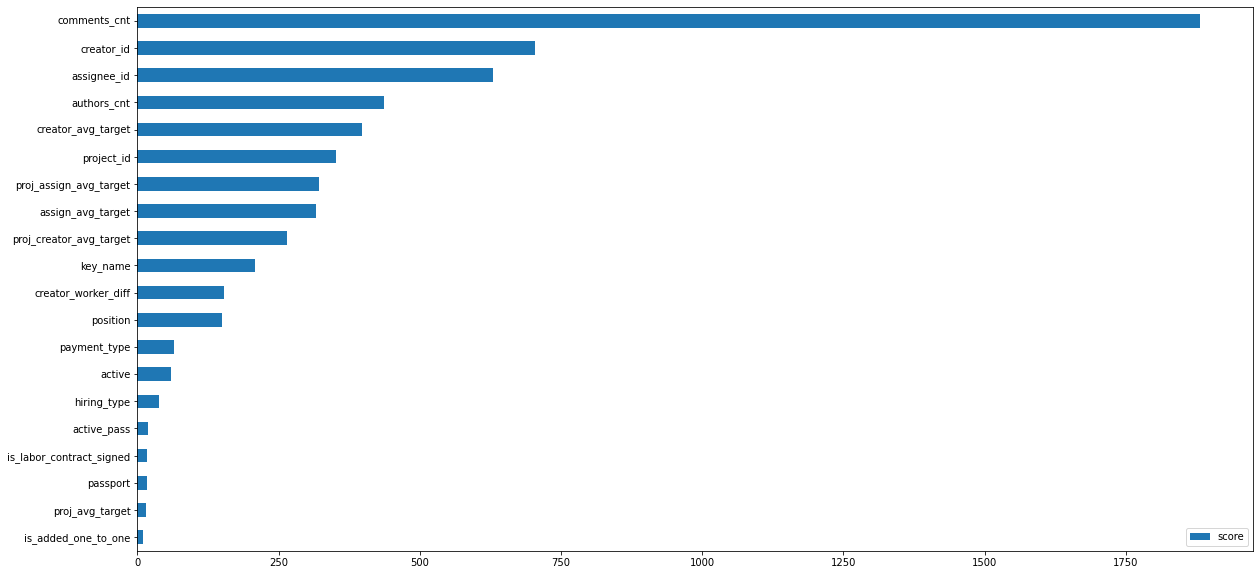

In [159]:
feature_importance = model.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys,
                    columns=["score"]).sort_values(by="score", ascending=False)

data.nsmallest(40, columns="score").plot(kind='barh', figsize=(20, 10)) ## plot top 40 features

In [160]:
feature_importance

{'proj_creator_avg_target': 265,
 'proj_assign_avg_target': 322,
 'comments_cnt': 1882,
 'assign_avg_target': 316,
 'payment_type': 65,
 'key_name': 208,
 'creator_id': 704,
 'project_id': 351,
 'authors_cnt': 436,
 'position': 150,
 'assignee_id': 629,
 'creator_worker_diff': 153,
 'creator_avg_target': 398,
 'proj_avg_target': 16,
 'is_labor_contract_signed': 17,
 'hiring_type': 38,
 'passport': 17,
 'active_pass': 19,
 'active': 59,
 'is_added_one_to_one': 9}

## Предсказание на сайт

In [161]:
X_test = df_test.drop(['minute', 'hour', 'day', 'key_num', 'month'], axis=1)
prediction = model.predict(X_test)
prediction = np.exp(prediction)
prediction = np.rint(prediction).astype('int64')
prediction

array([15482,  9905, 11045, ...,  3654,  3654,  4812])

In [162]:
df_sample = pd.read_csv('./data/sample_solution.csv')
df_sample.overall_worklogs = prediction
df_sample.head()

,id,overall_worklogs
0,675975,15482
1,675972,9905
2,675965,11045
3,675961,13167
4,675955,9798


In [163]:
df_sample.to_csv('./solutions/d7_new_features.csv', index=False)

## Проверка предсказания

In [164]:
df_solution = pd.read_csv('./solutions/d7_new_features.csv')
df_solution.head()

,id,overall_worklogs
0,675975,15482
1,675972,9905
2,675965,11045
3,675961,13167
4,675955,9798
